## Environment set up and import Libraries

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


In [7]:
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [8]:
import os, keras, numpy
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *

## **Discriminator** Model

In [10]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):

  # input level
  in_label = Input(shape=(1,), name = "input_label")
  li = Embedding(n_classes, 50)(in_label)
  li = Dense(in_shape[0] * in_shape[1])(li)
  li = Reshape((in_shape[0], in_shape[1], 1))(li)

  # input image
  in_image = Input(shape=in_shape, name = "input_image")

  # concate 1
  merge = Concatenate()([in_image, li])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Embedding(n_classes, 50)(in_label)
  se1 = Dense(14*14, activation='relu')(se1)
  se1 = Reshape((14, 14, 1))(se1)

  merge1 = Concatenate()([fe, se1])

  fe = Conv2D(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)
  fe = Flatten()(fe)
  fe = Dropout(0.2)(fe)
  
  # final layer
  out_layer = Dense(1, activation='sigmoid')(fe)

  model = Model([in_image, in_label], out_layer)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
a = define_discriminator()
a.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_label (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_label[0][0]']            
                                                                                                  
 dense_3 (Dense)                (None, 1, 784)       39984       ['embedding_2[0][0]']            
                                                                                                  
 input_image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                            

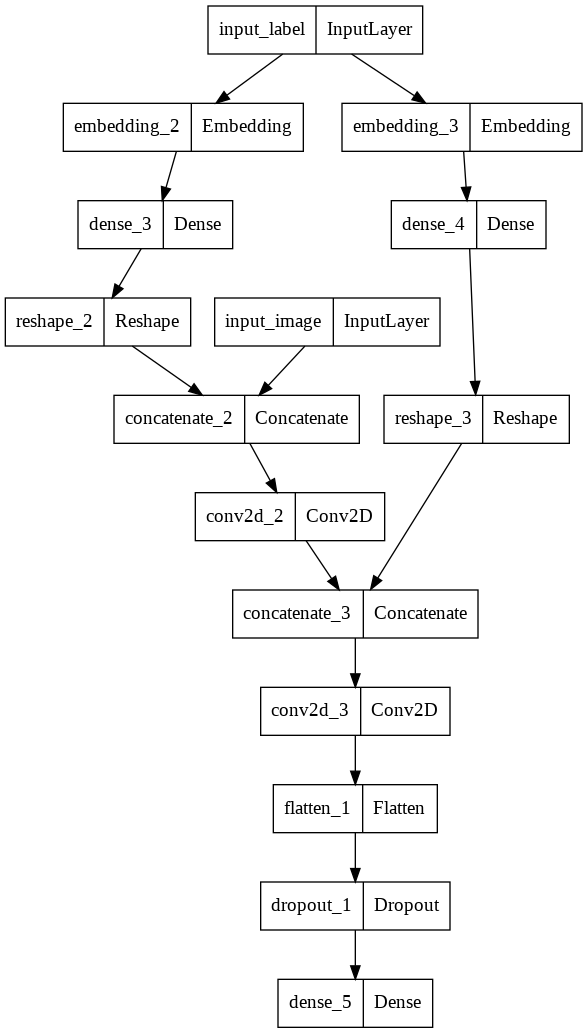

In [11]:
# plot the discriminator model
tf.keras.utils.plot_model(a)

## **Generator** Model

In [12]:
def define_generator(latent_dim = 100, n_classes=10):

  # label input
  in_label = Input(shape=(1,), name='in_label')
  li_embedd = Embedding(n_classes, 50)(in_label)
  li = Dense(7 * 7, activation='relu')(li_embedd)
  li = Reshape((7, 7, 1))(li)

  # latent input
  in_latent = Input(shape=(latent_dim,), name='in_latent')

  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes, activation = 'relu')(in_latent)
  gen = Reshape((7, 7, 128))(gen)

  # concate 1
  merge = Concatenate()([gen, li])

  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge)

  # concate 2
  se1 = Dense(14*14, activation='relu')(li_embedd)
  se1 = Reshape((14, 14, 1))(se1)
  merge1 = Concatenate()([gen, se1])
  gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', activation = 'relu')(merge1)

  # final layer
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

  model = Model([in_latent, in_label], out_layer)
  return model
b = define_generator(100)
b.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        500         ['in_label[0][0]']               
                                                                                                  
 dense_7 (Dense)                (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                            

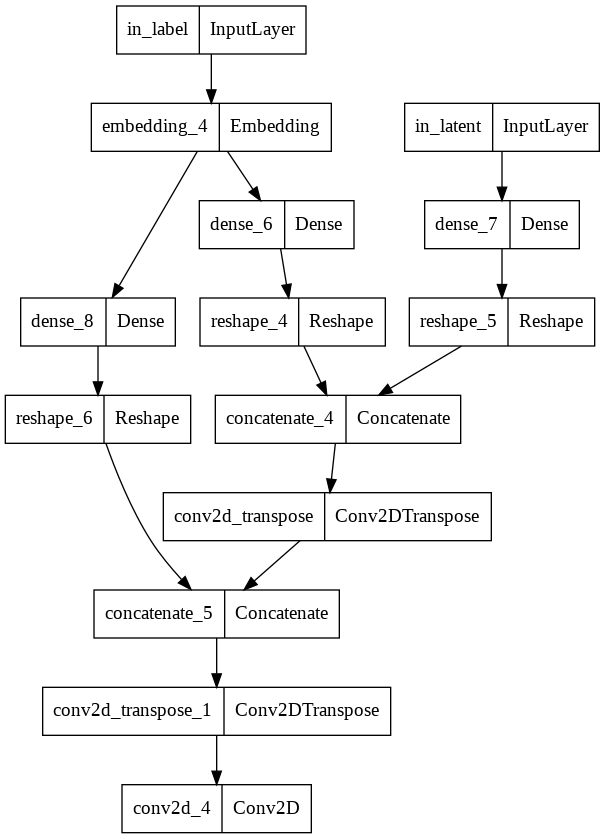

In [16]:
# plot the generator model
tf.keras.utils.plot_model(b)

## **Combine** or **GAN** Model

In [14]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  gen_noise, gen_label = g_model.input
  gen_output = g_model.output

  gan_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_label (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 in_latent (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        500         ['in_label[0][0]']               
                                                                                                  
 dense_7 (Dense)                (None, 6272)         633472      ['in_latent[0][0]']              
                                                                                            

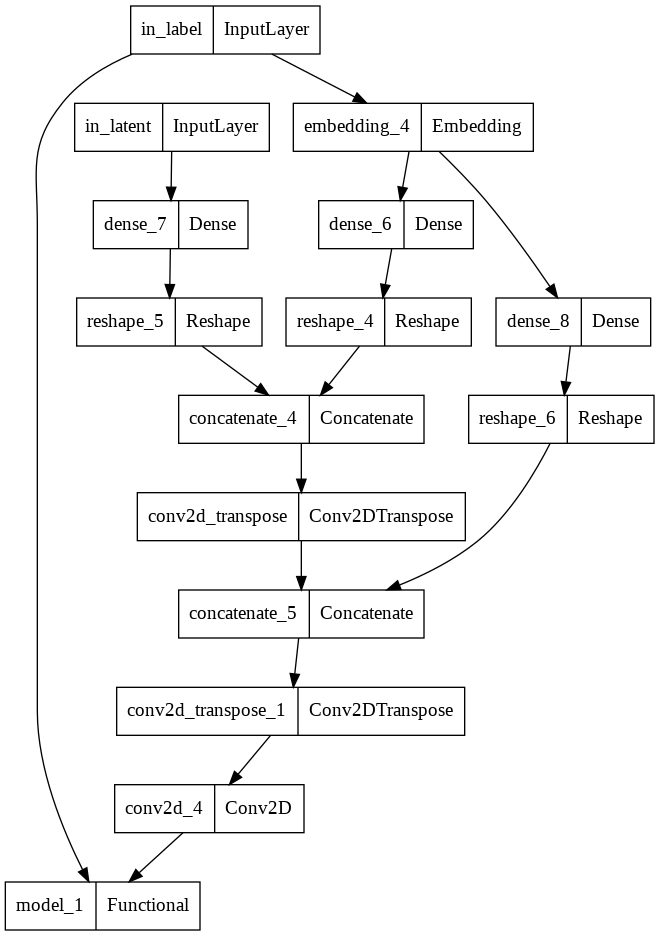

In [17]:
# plot GAN model
tf.keras.utils.plot_model(c)

## Load Mnist Dataset

In [24]:
def load_real_samples():
  # load dataset
  (trainX, trainy), (_, _) = mnist.load_data()
  # expand to 3d, e.g. add channels
  X = expand_dims(trainX, axis=-1)
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]
k = load_real_samples()
print("image: ",k[0].shape," Lable: ",k[1].shape)
print("\nshape/size of the first 16 data: ",k[0][:16].shape)

image:  (60000, 28, 28, 1)  Lable:  (60000,)

shape/size of the first 16 data:  (16, 28, 28, 1)


## Plot data with label

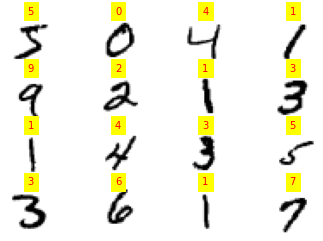

In [25]:
def save_plot(x_input,lebel,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.title(str(lebel[i]),fontsize=10,color="red",fontweight=10,pad='2.0',backgroundcolor='yellow')
        plt.imshow(x_input[i,:,:,0], cmap = 'gray_r')
        plt.axis('off')
    plt.show()
# plot data
save_plot(k[0][:16], k[1][:16])

## Generate real sample function

In [28]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = ones((n_samples, 1))
	return [X, labels], y
d = generate_real_samples(k, 32)
print("Generate real data as a batch randomly: ",d[0][0].shape)

Generate real data as a batch randomly:  (32, 28, 28, 1)


## Generate latent point function

In [32]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = randint(0, n_classes, n_samples)
  return [z_input, labels]
p = generate_latent_points(100, 32)
print("Generate latent point(with label) as a batch: ",p[0].shape,p[1].shape)

Generate latent point(with label) as a batch:  (32, 100) (32,)


## Generate Fake samples of image with label

In [34]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = zeros((n_samples, 1))
	return [images, labels_input], y
with tf.device(device_name):
  kh = generate_fake_samples(b, 100, 32)
  print("shape of the generated images: ",kh[0][0].shape)

shape of the generated images:  (32, 28, 28, 1)


## Summarize the generator model

In [40]:
def summarize_the_model(generator, latent_dim = 100):
    latent_points, labels = generate_latent_points(latent_dim= 100, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X,labels, n=4)

## Train function

In [41]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  print("batch per epoch: ", bat_per_epo)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += d_loss1

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += d_loss2

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += g_loss1

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %.2f, discriminator_loss_for_fake_data = %.2f, generator_loss = %.2f\n' %(i+1, n_epochs, d_loss_r, d_loss_f, g_loss))
    summarize_the_model(g_model)
    # g_model.compiled_metrics == None

    # if i == 0:
    #   # g_model.compiled_metrics == None
    #   g_model.save("g_gan_model.h5")
    # os.remove("g_gan_model.h5")
    # g_model.compiled_metrics == None
    g_model.save("g_gan_model.h5")
    print("\n")

## Main function


READY TO GO !!!

No. of epoch:  20
batch per epoch:  468
half batch:  64 

************************************************** 


epoch -> [1/20], discriminator_loss_for_real_data = 246.91, discriminator_loss_for_fake_data = 263.13, generator_loss = 665.01



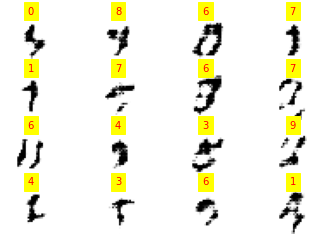



epoch -> [2/20], discriminator_loss_for_real_data = 314.30, discriminator_loss_for_fake_data = 314.03, generator_loss = 377.13



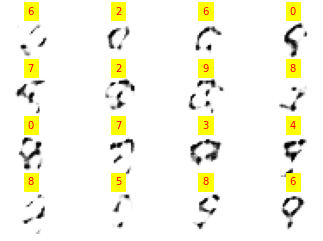



epoch -> [3/20], discriminator_loss_for_real_data = 289.60, discriminator_loss_for_fake_data = 290.17, generator_loss = 414.57



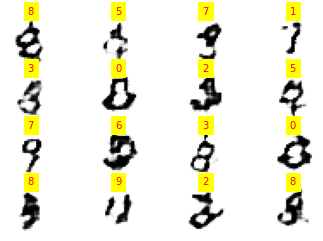



epoch -> [4/20], discriminator_loss_for_real_data = 299.48, discriminator_loss_for_fake_data = 300.40, generator_loss = 399.90



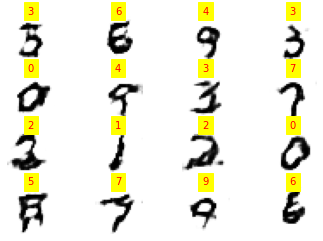



epoch -> [5/20], discriminator_loss_for_real_data = 293.41, discriminator_loss_for_fake_data = 293.45, generator_loss = 413.51



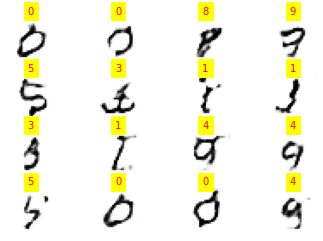



epoch -> [6/20], discriminator_loss_for_real_data = 285.23, discriminator_loss_for_fake_data = 286.99, generator_loss = 431.85



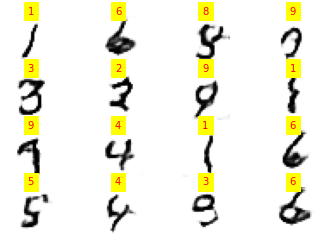



epoch -> [7/20], discriminator_loss_for_real_data = 282.64, discriminator_loss_for_fake_data = 283.69, generator_loss = 448.79



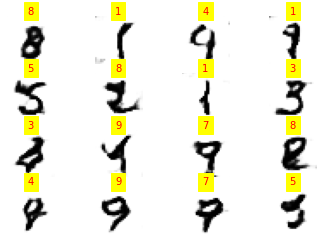



epoch -> [8/20], discriminator_loss_for_real_data = 286.77, discriminator_loss_for_fake_data = 286.28, generator_loss = 444.42



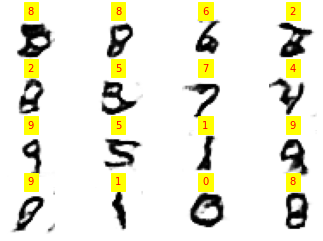



epoch -> [9/20], discriminator_loss_for_real_data = 288.29, discriminator_loss_for_fake_data = 286.83, generator_loss = 446.89



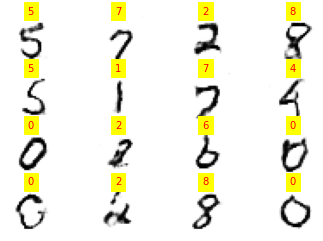



epoch -> [10/20], discriminator_loss_for_real_data = 292.52, discriminator_loss_for_fake_data = 290.57, generator_loss = 441.93



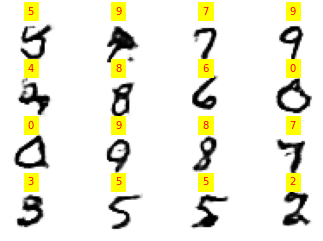



epoch -> [11/20], discriminator_loss_for_real_data = 294.90, discriminator_loss_for_fake_data = 292.39, generator_loss = 433.16



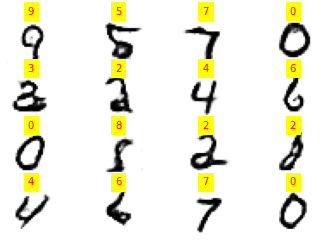



epoch -> [12/20], discriminator_loss_for_real_data = 298.05, discriminator_loss_for_fake_data = 294.72, generator_loss = 426.66



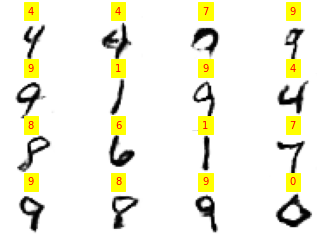



epoch -> [13/20], discriminator_loss_for_real_data = 300.48, discriminator_loss_for_fake_data = 296.29, generator_loss = 420.34



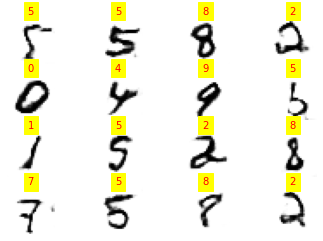



epoch -> [14/20], discriminator_loss_for_real_data = 302.74, discriminator_loss_for_fake_data = 298.12, generator_loss = 416.20



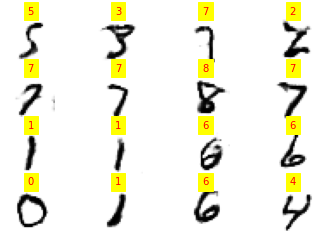



epoch -> [15/20], discriminator_loss_for_real_data = 302.92, discriminator_loss_for_fake_data = 298.65, generator_loss = 413.30



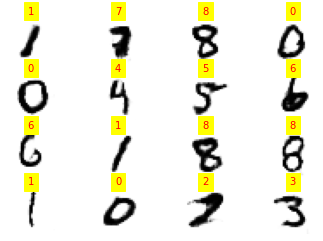



epoch -> [16/20], discriminator_loss_for_real_data = 304.49, discriminator_loss_for_fake_data = 300.34, generator_loss = 407.66



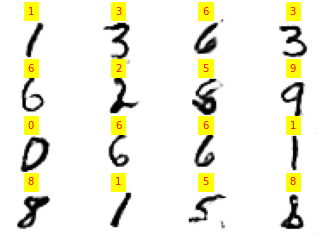



epoch -> [17/20], discriminator_loss_for_real_data = 303.72, discriminator_loss_for_fake_data = 300.58, generator_loss = 407.18



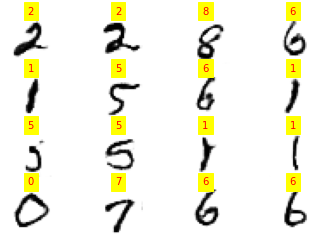



epoch -> [18/20], discriminator_loss_for_real_data = 304.61, discriminator_loss_for_fake_data = 301.30, generator_loss = 406.80



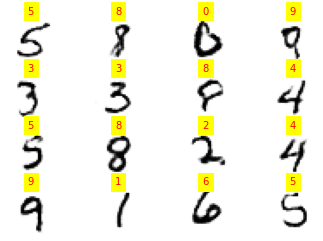



epoch -> [19/20], discriminator_loss_for_real_data = 304.10, discriminator_loss_for_fake_data = 300.94, generator_loss = 405.59



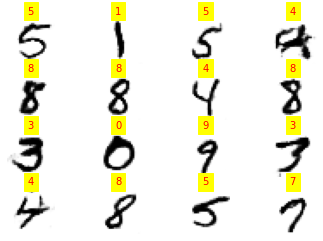



epoch -> [20/20], discriminator_loss_for_real_data = 304.50, discriminator_loss_for_fake_data = 300.87, generator_loss = 404.44



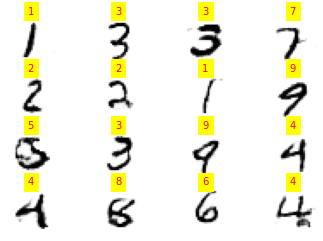

In [43]:
with tf.device(device_name):

  latent_dim = 100
  n_epochs = 20
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

# Prediction

latent points(latent points and labels):  (16, 100) (16,)

Generated images with labels:  (16, 28, 28, 1) 



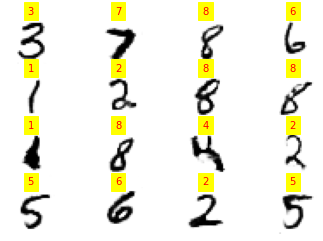

In [46]:
latent_dim = 100
n_samples = 16
z_input, labels = generate_latent_points(latent_dim, n_samples)
print("latent points(latent points and labels): ",z_input.shape, labels.shape)
data = [z_input,labels]
pred = g_model.predict(data)
pred = (pred +1 ) / 2.0
print("\nGenerated images with labels: ",pred.shape,'\n')
save_plot(pred,labels,n=4)

# Others

In [ ]:
# # save the model
# model_json = g_model.to_json()
# with open("generator12.json","w") as json_file:
#   json_file.write(model_json)

# # load the model
# from keras.models import model_from_json
# json_file = open("generator12.json","r")
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

In [ ]:
# latent_dim = 100
# n_samples = 16
# z_input, labels = generate_latent_points(latent_dim, n_samples)
# print(z_input.shape, labels.shape)
# data = [z_input,labels]
# pred = loaded_model.predict(data)
# pred = (pred +1 ) / 2.0
# print(pred.shape)
# save_plot(pred,labels,n=4)

In [ ]:
# latent_dim = 100
# n_samples = 16
# x_input = randn(latent_dim * n_samples)
# print(x_input.shape)
# z_input = x_input.reshape(n_samples, latent_dim)
# print(z_input.shape)
# import numpy as np
# n_classes = 10
# labels = randint(0, n_classes, n_samples)
# print(labels)
# labels = labels.reshape(n_samples,)
# print(labels.shape)
# data = [z_input,labels]
# pred = loaded_model.predict(data)
# pred = (pred +1 ) / 2.0
# print(pred.shape)
# save_plot(pred,labels,n=4)

In [ ]:
# import os
# os.remove("generator.json")

In [ ]:
# g_model.save("generatorh5.h5")
# from keras.models import load_model
# # model = load_model('generatorh5.h5')